In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xesmf as xe

/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
ds = xr.open_dataset(
    '/project/meteo/scratch/S.Rasp/weather-benchmark/raw/geopotential_500/geopotential_500_1979_raw.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 8760)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-12-31T23:00:00
Data variables:
    z          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [4]:
ds_small = ds.isel(time=slice(0, 1000))

In [5]:
# Have to rename to lat/lon
ds_small = ds_small.rename({'latitude': 'lat', 'longitude': 'lon'})

In [6]:
# Have to rename to lat/lon
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})

## Regrid with xesmf

In [2]:
res = 180 / 32; res

5.625

In [7]:
lat_out = np.arange(-90+res/2, 90, res)

In [8]:
lon_out = np.arange(0, 360, res)

In [9]:
lat_out.shape, lon_out.shape

((32,), (64,))

In [10]:
lat_out

array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625,
       -53.4375, -47.8125, -42.1875, -36.5625, -30.9375, -25.3125,
       -19.6875, -14.0625,  -8.4375,  -2.8125,   2.8125,   8.4375,
        14.0625,  19.6875,  25.3125,  30.9375,  36.5625,  42.1875,
        47.8125,  53.4375,  59.0625,  64.6875,  70.3125,  75.9375,
        81.5625,  87.1875])

In [11]:
grid_out = xr.Dataset(
    {
        'lat': (['lat'], lat_out),
        'lon': (['lon'], lon_out),
    }
)
grid_out

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64)
Coordinates:
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    *empty*

In [12]:
regridder = xe.Regridder(ds_small, grid_out, 'bilinear', periodic=True, reuse_weights=True)

Overwrite existing file: bilinear_721x1440_33x64_peri.nc 
 You can set reuse_weights=True to save computing time.


In [13]:
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_721x1440_33x64_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (721, 1440) 
Output grid shape:          (33, 64) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True

In [14]:
%%time
ds_xe = regridder(ds_small)

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
CPU times: user 7.17 s, sys: 4.51 s, total: 11.7 s
Wall time: 30 s


In [ ]:
%%time
ds_xe = regridder(ds)

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


In [15]:
ds.isel(time=slice(8000, 9000))

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 760)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * time     (time) datetime64[ns] 1979-11-30T08:00:00 ... 1979-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [21]:
len(ds.time) // 1000

8

In [23]:
from tqdm import tqdm_notebook as tqdm

In [28]:
%%time
ds_list = []
chunk_size = 250
n_chunks = len(ds.time) // chunk_size + 1
for i in tqdm(range(n_chunks+1)):
    ds_small = ds.isel(time=slice(i*chunk_size, (i+1)*chunk_size))
    ds_list.append(regridder(ds_small))

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


In [30]:
%%time
ds_list = []
chunk_size = 500
n_chunks = len(ds.time) // chunk_size + 1
for i in tqdm(range(n_chunks+1)):
    ds_small = ds.isel(time=slice(i*chunk_size, (i+1)*chunk_size))
    ds_list.append(regridder(ds_small))

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


In [ ]:
%%time
ds_list = []
chunk_size = 1000
n_chunks = len(ds.time) // chunk_size + 1
for i in tqdm(range(n_chunks+1)):
    ds_small = ds.isel(time=slice(i*chunk_size, (i+1)*chunk_size))
    ds_list.append(regridder(ds_small))

using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


In [29]:
ds_out = xr.concat(ds_list, dim='time')

In [19]:
ds_out

<xarray.Dataset>
Dimensions:  (concat_dims: 8, lat: 33, lon: 64, time: 8000)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-11-30T07:00:00
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
Dimensions without coordinates: concat_dims
Data variables:
    z        (concat_dims, time, lat, lon) float64 5.149e+04 ... 4.782e+04
Attributes:
    regrid_method:  bilinear

In [14]:
ds_xe

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64, time: 500)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 1979-01-21T19:00:00
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
Data variables:
    z        (time, lat, lon) float64 5.149e+04 5.149e+04 ... 5.156e+04
Attributes:
    regrid_method:  bilinear

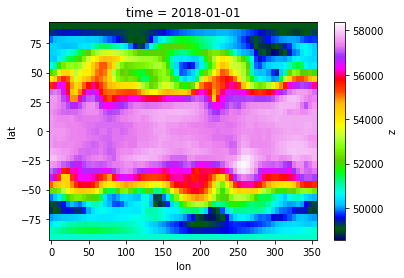

In [53]:
ds_out.z.isel(time=0).plot(cmap='gist_ncar')

In [54]:
ds_out.to_netcdf('./test_6deg.nc')

In [56]:
!ls -lh ./test_6deg.nc

-rw-r--r--  1 stephanrasp  staff   405K Sep 17 13:55 ./test_6deg.nc


In [57]:
0.4 * 365 /1000, 0.4 * 365 /1000 * 40

(0.146, 5.84)

In [23]:
1979-2016

-37

In [58]:
ds = xr.open_dataset('../src/single_test.nc')

In [59]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 2)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1980-01-01 2010-01-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slt        (time, latitude, longitude) float32 ...
    tisr       (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-17 12:03:16 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

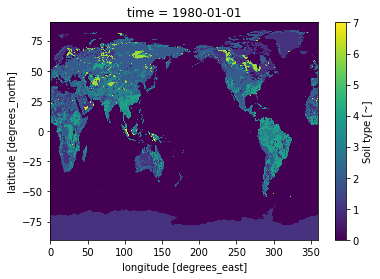

In [71]:
ds.slt.isel(time=0).plot()

In [73]:
60*693 / 1000

41.58

In [76]:
1/5.625**2 * 1000

31.60493827160494

In [77]:
5.8*60

348.0

In [79]:
2.5**2 / 2**2

1.5625

In [80]:
3/1.5

2.0

In [82]:
2*365/1000 * 40

29.2

In [83]:
30*60

1800